In [1]:
!python -V

Python 3.9.20


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [6]:
import mlflow


mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops_zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1733127854674, experiment_id='1', last_update_time=1733127854674, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
df = pd.read_parquet('/workspaces/mlops_zoomcamp/data/green_tripdata_2024-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

np.float64(7.1228220948023795)

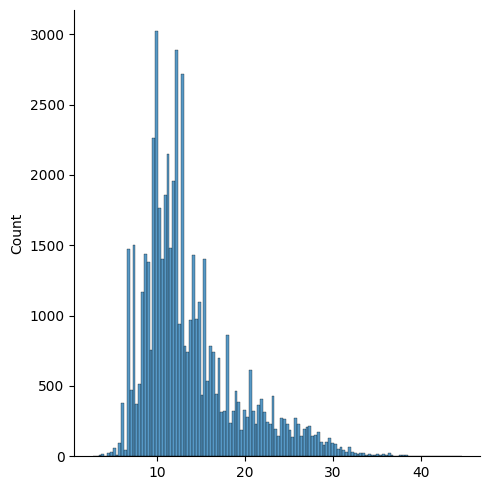

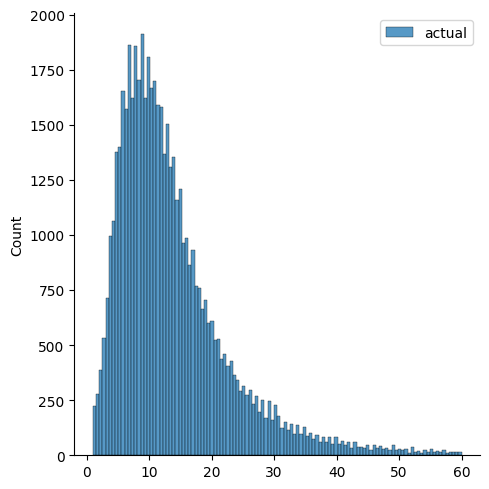

In [9]:
sns.displot(y_pred, label='prediction')
sns.displot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('/workspaces/mlops_zoomcamp/data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('/workspaces/mlops_zoomcamp/data/green_tripdata_2024-02.parquet')

In [12]:
len(df_train), len(df_val)

(54373, 51497)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

np.float64(5.9947992164797)

In [29]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
with mlflow.start_run():
    # Set tags and parameters
    mlflow.set_tag("developer", "christian")
    mlflow.log_param('train-data-path', "/workspaces/mlops_zoomcamp/data/green_tripdata_2024-01.parquet")
    mlflow.log_param('val-data-path', "/workspaces/mlops_zoomcamp/data/green_tripdata_2024-02.parquet")

    # Model training and evaluation
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    # Log artifact
    mlflow.log_artifact(local_path="/workspaces/mlops_zoomcamp/02-experiment-tracking/models/lin_reg.bin", artifact_path="modeles_pickle")


In [23]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [24]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [25]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [26]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:29:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.09491                           
[1]	validation-rmse:7.33095                           
[2]	validation-rmse:6.77086                           
[3]	validation-rmse:6.36131                           
[4]	validation-rmse:6.07131                           
[5]	validation-rmse:5.86259                           
[6]	validation-rmse:5.70685                           
[7]	validation-rmse:5.59992                           
[8]	validation-rmse:5.52875                           
[9]	validation-rmse:5.46592                           
[10]	validation-rmse:5.42651                          
[11]	validation-rmse:5.39997                          
[12]	validation-rmse:5.38164                          
[13]	validation-rmse:5.35988                          
[14]	validation-rmse:5.35051                          
[15]	validation-rmse:5.34092                          
[16]	validation-rmse:5.33436                          
[17]	validation-rmse:5.32900                          
[18]	valid

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:30:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.81510                                                     
[1]	validation-rmse:5.47362                                                     
[2]	validation-rmse:5.41159                                                     
[3]	validation-rmse:5.39593                                                     
[4]	validation-rmse:5.37819                                                     
[5]	validation-rmse:5.37617                                                     
[6]	validation-rmse:5.36722                                                     
[7]	validation-rmse:5.34599                                                     
[8]	validation-rmse:5.34941                                                     
[9]	validation-rmse:5.34869                                                     
[10]	validation-rmse:5.34580                                                    
[11]	validation-rmse:5.34882                                                    
[12]	validation-rmse:5.34836

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:30:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.32674                                                     
[1]	validation-rmse:5.52244                                                     
[2]	validation-rmse:5.32562                                                     
[3]	validation-rmse:5.27499                                                     
[4]	validation-rmse:5.25674                                                     
[5]	validation-rmse:5.24975                                                     
[6]	validation-rmse:5.24704                                                     
[7]	validation-rmse:5.24685                                                     
[8]	validation-rmse:5.24535                                                     
[9]	validation-rmse:5.24065                                                     
[10]	validation-rmse:5.24194                                                    
[11]	validation-rmse:5.24163                                                    
[12]	validation-rmse:5.24076

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:30:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.81609                                                    
[1]	validation-rmse:6.94025                                                    
[2]	validation-rmse:6.36589                                                    
[3]	validation-rmse:5.99975                                                    
[4]	validation-rmse:5.77234                                                    
[5]	validation-rmse:5.63113                                                    
[6]	validation-rmse:5.54330                                                    
[7]	validation-rmse:5.48530                                                    
[8]	validation-rmse:5.44638                                                    
[9]	validation-rmse:5.41979                                                    
[10]	validation-rmse:5.40188                                                   
[11]	validation-rmse:5.39103                                                   
[12]	validation-rmse:5.38152            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:31:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.70782                                                    
[1]	validation-rmse:5.41203                                                    
[2]	validation-rmse:5.36693                                                    
[3]	validation-rmse:5.34931                                                    
[4]	validation-rmse:5.32274                                                    
[5]	validation-rmse:5.31554                                                    
[6]	validation-rmse:5.31099                                                    
[7]	validation-rmse:5.30505                                                    
[8]	validation-rmse:5.30011                                                    
[9]	validation-rmse:5.29489                                                    
[10]	validation-rmse:5.29188                                                   
[11]	validation-rmse:5.28663                                                   
[12]	validation-rmse:5.28634            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:31:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.32370                                                    
[1]	validation-rmse:6.31838                                                    
[2]	validation-rmse:5.78352                                                    
[3]	validation-rmse:5.50628                                                    
[4]	validation-rmse:5.36966                                                    
[5]	validation-rmse:5.29860                                                    
[6]	validation-rmse:5.25927                                                    
[7]	validation-rmse:5.23987                                                    
[8]	validation-rmse:5.22329                                                    
[9]	validation-rmse:5.21355                                                    
[10]	validation-rmse:5.20865                                                   
[11]	validation-rmse:5.20351                                                   
[12]	validation-rmse:5.19996            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:32:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.24530                                                    
[1]	validation-rmse:7.56656                                                    
[2]	validation-rmse:7.04147                                                    
[3]	validation-rmse:6.64099                                                    
[4]	validation-rmse:6.33765                                                    
[5]	validation-rmse:6.11089                                                    
[6]	validation-rmse:5.94251                                                    
[7]	validation-rmse:5.81768                                                    
[8]	validation-rmse:5.72522                                                    
[9]	validation-rmse:5.65764                                                    
[10]	validation-rmse:5.60687                                                   
[11]	validation-rmse:5.56892                                                   
[12]	validation-rmse:5.53969            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:33:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.95776                                                    
[1]	validation-rmse:7.11794                                                    
[2]	validation-rmse:6.51882                                                    
[3]	validation-rmse:6.09924                                                    
[4]	validation-rmse:5.81351                                                    
[5]	validation-rmse:5.62030                                                    
[6]	validation-rmse:5.49146                                                    
[7]	validation-rmse:5.40712                                                    
[8]	validation-rmse:5.35098                                                    
[9]	validation-rmse:5.31432                                                    
[10]	validation-rmse:5.28675                                                   
[11]	validation-rmse:5.27043                                                   
[12]	validation-rmse:5.25773            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:34:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.64925                                                    
[1]	validation-rmse:5.42291                                                    
[2]	validation-rmse:5.40520                                                    
[3]	validation-rmse:5.40341                                                    
[4]	validation-rmse:5.39558                                                    
[5]	validation-rmse:5.39641                                                    
[6]	validation-rmse:5.39822                                                    
[7]	validation-rmse:5.40115                                                    
[8]	validation-rmse:5.39908                                                    
[9]	validation-rmse:5.39958                                                    
[10]	validation-rmse:5.39376                                                   
[11]	validation-rmse:5.38952                                                   
[12]	validation-rmse:5.39133            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:34:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.95339                                                    
[1]	validation-rmse:6.01013                                                    
[2]	validation-rmse:5.60961                                                    
[3]	validation-rmse:5.43507                                                    
[4]	validation-rmse:5.36940                                                    
[5]	validation-rmse:5.32108                                                    
[6]	validation-rmse:5.30851                                                    
[7]	validation-rmse:5.29956                                                    
[8]	validation-rmse:5.29325                                                    
[9]	validation-rmse:5.28612                                                    
[10]	validation-rmse:5.28289                                                   
[11]	validation-rmse:5.28209                                                   
[12]	validation-rmse:5.27318            

In [27]:
mlflow.xgboost.autolog(disable=True)

In [41]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.7327262797059472,
        'max_depth': 60,
        'min_child_weight': 0.39751357019312933,
        'objective': 'reg:linear',
        'reg_alpha': 0.04384913313287941,
        'reg_lambda': 0.003455704057912804,
        'seed': 42
    }

    mlflow.log_params(best_params)

    mlflow.log_param('train-data-path', "/workspaces/mlops_zoomcamp/data/green_tripdata_2024-01.parquet")
    mlflow.log_param('val-data-path', "/workspaces/mlops_zoomcamp/data/green_tripdata_2024-02.parquet")

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:06:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:5.81510
[1]	validation-rmse:5.47362
[2]	validation-rmse:5.41159
[3]	validation-rmse:5.39593
[4]	validation-rmse:5.37819
[5]	validation-rmse:5.37617
[6]	validation-rmse:5.36722
[7]	validation-rmse:5.34599
[8]	validation-rmse:5.34941
[9]	validation-rmse:5.34869
[10]	validation-rmse:5.34580
[11]	validation-rmse:5.34882
[12]	validation-rmse:5.34836
[13]	validation-rmse:5.35309
[14]	validation-rmse:5.34908
[15]	validation-rmse:5.35054
[16]	validation-rmse:5.35140
[17]	validation-rmse:5.34879
[18]	validation-rmse:5.34626
[19]	validation-rmse:5.34478
[20]	validation-rmse:5.34494
[21]	validation-rmse:5.34550
[22]	validation-rmse:5.34711
[23]	validation-rmse:5.35075
[24]	validation-rmse:5.35075
[25]	validation-rmse:5.35204
[26]	validation-rmse:5.35128
[27]	validation-rmse:5.35565
[28]	validation-rmse:5.35624
[29]	validation-rmse:5.35499
[30]	validation-rmse:5.35634
[31]	validation-rmse:5.35746
[32]	validation-rmse:5.36256
[33]	validation-rmse:5.36340
[34]	validation-rmse:5.3

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:06:31] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2024/12/02 09:06:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [35]:
logged_model = 'runs:/828f6b15bae947c7b97f7c0c0be3a45d/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [36]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 828f6b15bae947c7b97f7c0c0be3a45d

In [37]:
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

In [38]:
y_pred = xgboost_model.predict(valid)

In [39]:
y_pred[:10]

array([19.315    , 27.35246  ,  9.101054 ,  9.060632 ,  3.4180484,
        6.8914914,  9.060706 , 12.592101 , 21.323027 ,  6.4239635],
      dtype=float32)

In [40]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "/workspaces/mlops_zoomcamp/data/green_tripdata_2024-01.parquet")
        mlflow.log_param("valid-data-path", "/workspaces/mlops_zoomcamp/data/green_tripdata_2024-01.parquet")
        
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

2024/12/02 08:55:12 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
2024/12/02 08:58:59 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
2024/12/02 08:59:05 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
2024/12/02 09:06:11 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
